In [53]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Metric definition

In [46]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Data loading

In [6]:
!unzip data/quora.csv.zip

Archive:  data/quora.csv.zip
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [8]:
data = pd.read_csv('quora.csv')

In [28]:
train_texts, test_texts, train_y, test_y = train_test_split(data.question_text, data.target, test_size=0.1, stratify=data.target)

## Tiokenizing texts

In [29]:
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)

alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1


tk.word_index = char_dict.copy()

tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [30]:
MAX_LEN = 300

In [31]:
# Convert string to index
train_sequences = tk.texts_to_sequences(train_texts)
test_sequences = tk.texts_to_sequences(test_texts)

# Padding
train_data = pad_sequences(train_sequences, maxlen = MAX_LEN, padding='post')
test_data = pad_sequences(test_sequences, maxlen = MAX_LEN, padding='post')

# Convert to numpy array
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

In [32]:
from tensorflow.keras.utils import to_categorical

train_classes = to_categorical(train_y)
test_classes = to_categorical(test_y)

In [47]:
# =====================Char CNN=======================
# parameter
input_size = MAX_LEN
vocab_size = len(tk.word_index)
embedding_size = 69
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]

fully_connected_layers = [MAX_LEN, MAX_LEN]
num_of_classes = 2
dropout_p = 0.5
optimizer = 'adam'
loss = 'binary_crossentropy'

# Embedding weights
embedding_weights = []  # (70, 69)
embedding_weights.append(np.zeros(vocab_size))  # (0, 69)

for char, i in tk.word_index.items():  # from index 1 to 69
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
print('Load')

# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_size,
                            input_length=input_size,
                            weights=[embedding_weights])

# Model Construction
# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)
# Embedding
x = embedding_layer(inputs)
# Conv
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)  # Final shape=(None, 34, 256)
x = Flatten()(x)  # (None, 8704)
# Fully connected layers
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)  # dense_size == 1024
    x = Dropout(dropout_p)(x)
# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)
# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=[f1],)  # Adam, categorical_crossentropy
model.summary()

# Shuffle
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes

Load
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 69)           4830      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 294, 256)          123904    
_________________________________________________________________
activation_18 (Activation)   (None, 294, 256)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 98, 256)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 92, 256)           459008    
_________________________________________________________________
activation_19 (Activation)   (None, 92, 256)          

In [48]:
import tensorflow as tf

In [49]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

## Training

In [50]:
from tqdm.keras import TqdmCallback

In [51]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=32,
          epochs=10,
          callbacks=[TqdmCallback(verbose=2), checkpoint, early_stop])

Epoch 1/10
36732/36735 [============================>.] - ETA: 0s - loss: 0.9489 - f1: 0.9381
Epoch 00001: val_f1 improved from -inf to 0.93813, saving model to model.weights
36735/36735 [==============================] - 482s 13ms/step - loss: 0.9489 - f1: 0.9381 - val_loss: 0.9489 - val_f1: 0.9381



Epoch 2/10
36732/36735 [============================>.] - ETA: 0s - loss: 0.9489 - f1: 0.9381
Epoch 00002: val_f1 did not improve from 0.93813
36735/36735 [==============================] - 482s 13ms/step - loss: 0.9489 - f1: 0.9381 - val_loss: 0.9489 - val_f1: 0.9381



Epoch 3/10
36732/36735 [============================>.] - ETA: 0s - loss: 0.9489 - f1: 0.9381
Epoch 00003: val_f1 did not improve from 0.93813
36735/36735 [==============================] - 482s 13ms/step - loss: 0.9489 - f1: 0.9381 - val_loss: 0.9489 - val_f1: 0.9381



Epoch 4/10
  342/36735 [..............................] - ETA: 7:36 - loss: 0.8829 - f1: 0.9424

KeyboardInterrupt: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


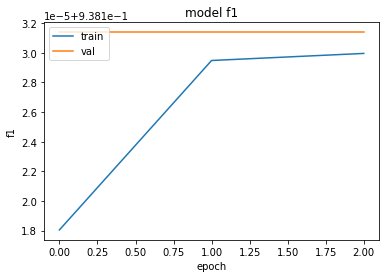

In [54]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we can see, even one epoch of training produces great results. loss: 0.9489 - f1: 0.9381 - val_loss: 0.9489 - val_f1: 0.9381